In [66]:
import json

with open('results/model-eval-amd-7950x3d-rtx4080.json', 'r') as file:
    data = json.load(file)

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

records = []
for model, tools in data.items():
    for tool, metrics in tools.items():
        records.append({
            'model': model,
            'tool': tool,
            'pass_percentage': metrics['pass_percentage'],
            'median_latency': metrics['median_latency'],
            'errors': metrics['errors']
        })

df = pd.DataFrame(records)

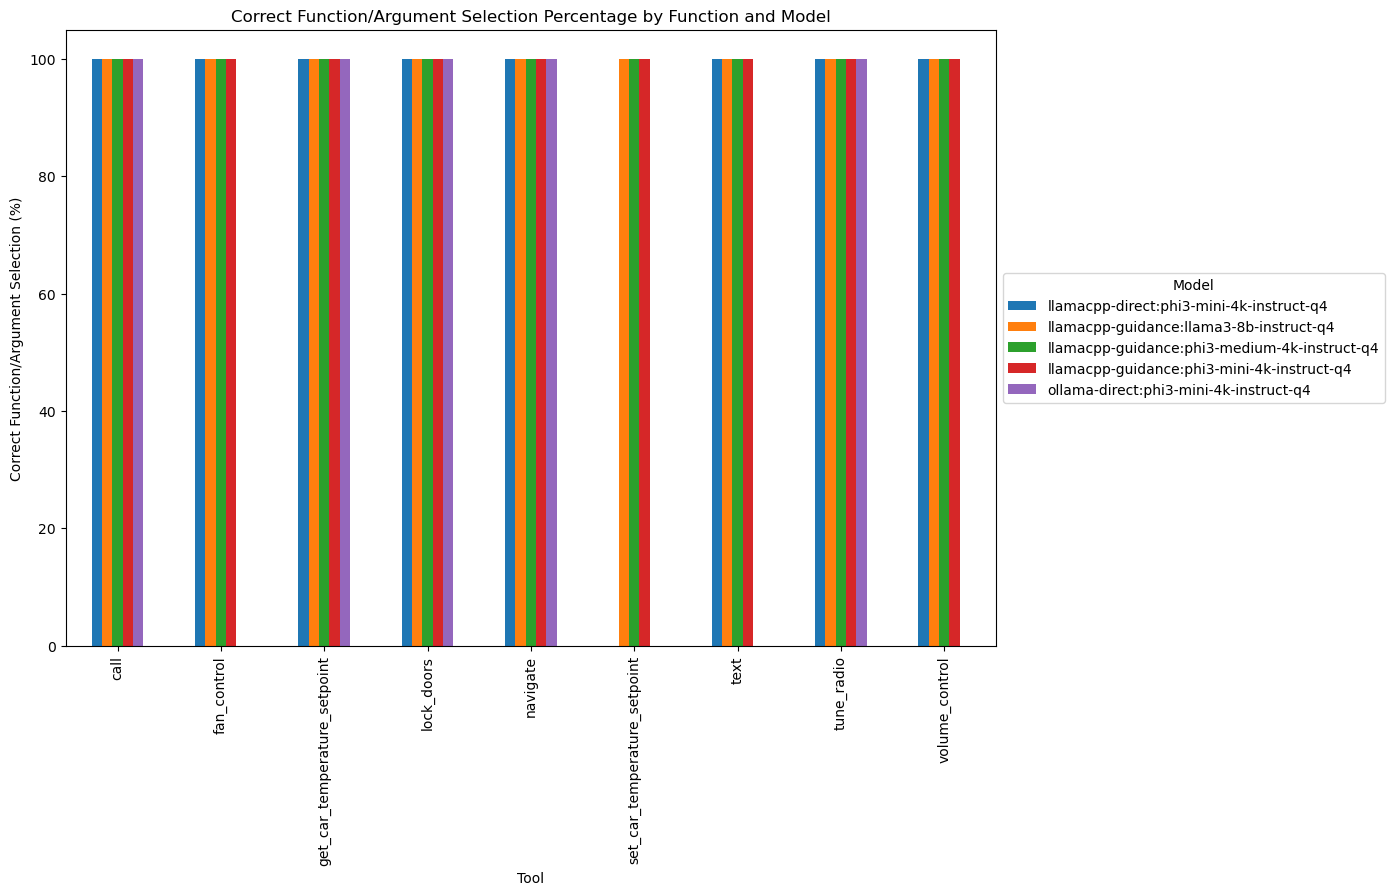

In [69]:

# Pivot the DataFrame to have models as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='model', values='pass_percentage')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Correct Function/Argument Selection Percentage by Function and Model')
plt.xlabel('Tool')
plt.ylabel('Correct Function/Argument Selection (%)')
plt.legend(title='Model', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

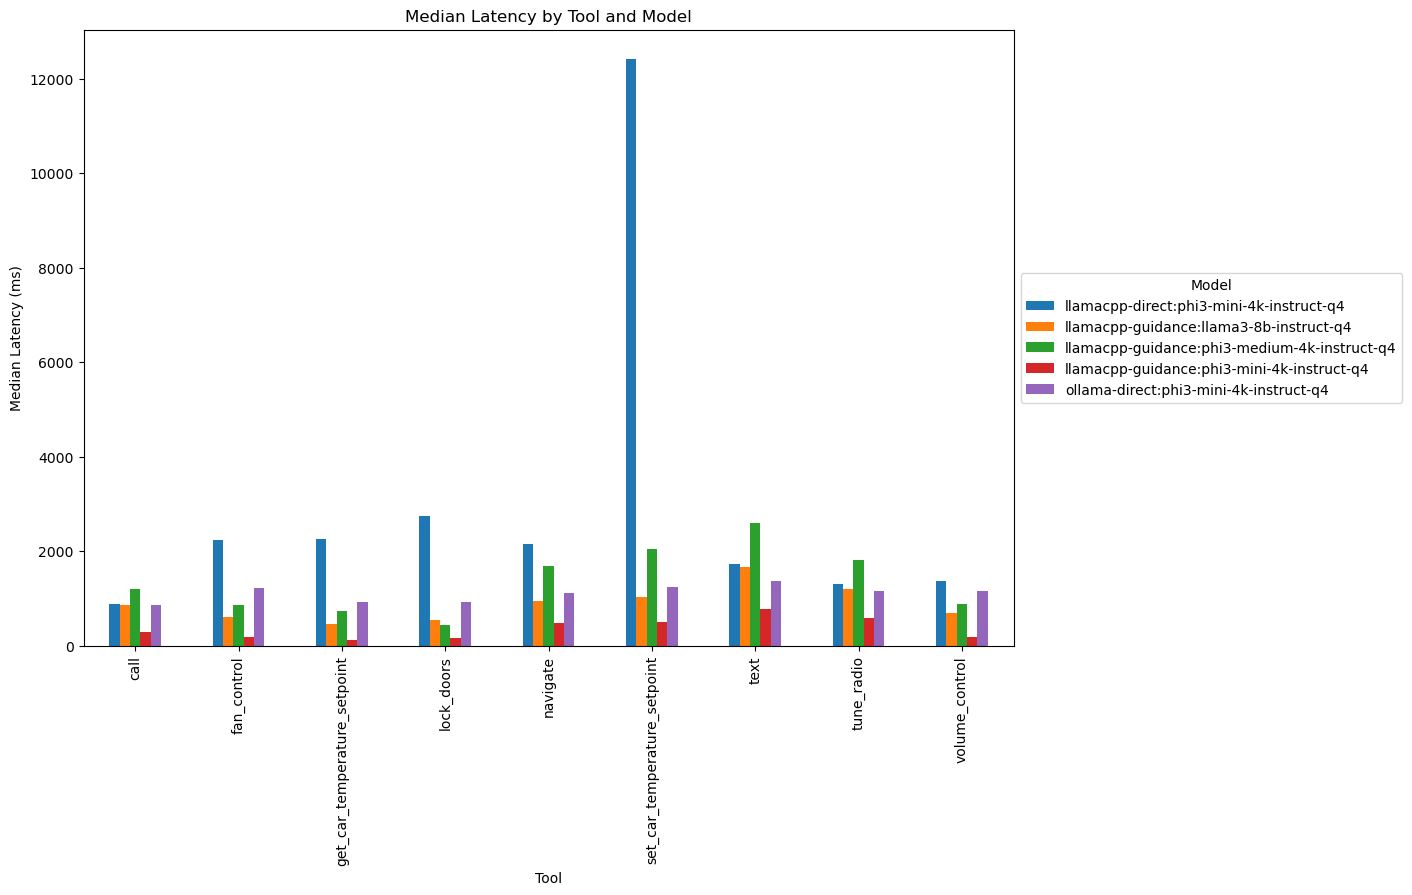

In [70]:
# Pivot the DataFrame to have models as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='model', values='median_latency')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Median Latency by Tool and Model')
plt.xlabel('Tool')
plt.ylabel('Median Latency (ms)')
plt.legend(title='Model', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [71]:
from tabulate import tabulate

def print_results(results):
    headers = ["f(x)", "p", "fi", "pi", "nfr", "i(bvfc)", "total", "%", "min (ms)", "mean", "median", "max (ms)"]

    data = []
    for pivot in results:
        pivot_results = results[pivot]
        if pivot_results["total_evaluations"] > 0:
            passed = pivot_results["passed"]
            function_incorrect = pivot_results["function_incorrect"]
            parameters_incorrect = pivot_results["parameters_incorrect"]
            non_function_response = pivot_results["non_function_response"]
            total_evaluations = pivot_results["total_evaluations"]
            incorrect_but_valid = pivot_results["incorrect_but_valid"]
            pass_percentage = pivot_results["pass_percentage"]

            min_latency = pivot_results["min_latency"]
            max_latency = pivot_results["max_latency"]
            mean_latency = pivot_results["mean_latency"]
            median_latency = pivot_results["median_latency"]

            data.append([pivot, passed, function_incorrect, parameters_incorrect, non_function_response, incorrect_but_valid, total_evaluations, pass_percentage, min_latency, mean_latency, median_latency, max_latency])  

    print(tabulate(data, headers=headers))
    
for config_tag in data:
    print(f"results for configuration: {config_tag}")
    print_results(data[config_tag])
    print()

results for configuration: llamacpp-direct:phi3-mini-4k-instruct-q4
f(x)                            p    fi    pi    nfr    i(bvfc)    total    %    min (ms)       mean     median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  ---  ----------  ---------  ---------  ----------
call                            1     0     0      0          0        1  100     888.679    888.679    888.679     888.679
fan_control                     1     0     0      0          0        1  100    2240.4     2240.4     2240.4      2240.4
get_car_temperature_setpoint    1     0     0      0          0        1  100    2261.86    2261.86    2261.86     2261.86
lock_doors                      1     0     0      0          0        1  100    2744.69    2744.69    2744.69     2744.69
navigate                        1     0     0      0          0        1  100    2155.21    2155.21    2155.21     2155.21
set_car_temperature_setpoint    0     0     0      1          0      

In [92]:
from IPython.display import display, HTML

errors_df = df[df['errors'].apply(lambda x: len(x) > 0)]
headers = ["user", "exp f(x)", "gen f(x)", "exp params", "gen params"]

for index, row in errors_df.iterrows():
    model_name = row['model']
    tool_name = row['tool']
    errors = row['errors']

    display(HTML(f"<b>Errors analysis for {tool_name} with config {model_name}</b>"))
    
    errors_table = []
    for error in errors:
        print()
        user_input = error["user_input"]
        
        expected_function = error["expected_function"]
        generated_function = error["generated_function"]
        
        if expected_function != generated_function:
            print(f"{user_input} -> expected f(x) {expected_function} vs. generated {generated_function}")

        expected_parameters = error["expected_parameters"]
        generated_parameters = error["generated_parameters"]
        
        if expected_parameters != generated_parameters:
            print(f'"{user_input}"')
            print(f"expected params:  {expected_parameters}")
            print(f"generated params: {generated_parameters}")

    print()
        


"Full fan please"
expected params:  {'level': 'max'}
generated params: [{'name': 'level', 'type': 'string', 'allowed_values': ['max']}]




"Set the thermostat to 67 degrees, please."
expected params:  {'temperature': 67}
generated params: [{'name': 'temperature', 'type': 'float'}]




"Please text Fiona Clarke that I am running late"
expected params:  {'name': 'Fiona Clarke', 'message': 'I am running late'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Fiona Clarke'}, {'name type': 'string', 'value': 'I am running late'}]




"Please lower the volume"
expected params:  {'volume': 'decrease'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['decrease']}]



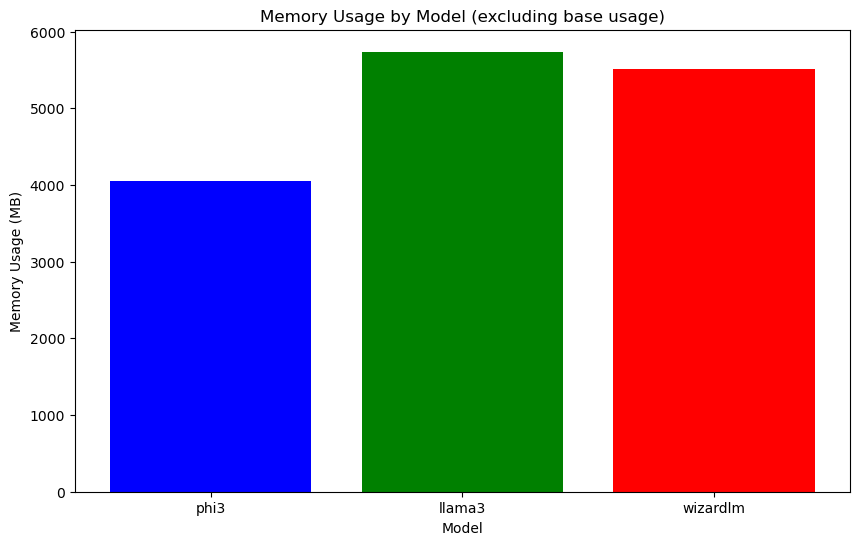

In [10]:
# Base memory usage
base_memory_usage = 1889 # MB

# Compute gross memory measurements with nvidia-smi minus base usage
phi3_memory_usage = 5935 - base_memory_usage # MB
llama3_memory_usage = 7626 - base_memory_usage # MB
wizardlm_memory_usage = 7403 - base_memory_usage # MB

# Data for plotting
models = ['phi3', 'llama3', 'wizardlm']
memory_usage = [phi3_memory_usage, llama3_memory_usage, wizardlm_memory_usage]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, memory_usage, color=['blue', 'green', 'red'])

plt.title('Memory Usage by Model (excluding base usage)')
plt.xlabel('Model')
plt.ylabel('Memory Usage (MB)')
plt.show()

In [28]:
with open('results/tool-count-eval-m1-max.json', 'r') as file:
    data = json.load(file)

In [29]:
records = []

for tool_count, tools in data.items():
    for tool, metrics in tools.items():
        records.append({
            'tool_count': tool_count,
            'tool': tool,
            'median_latency': metrics['median_latency'],
            'pass_percentage': metrics['pass_percentage'],
        })

df = pd.DataFrame(records)

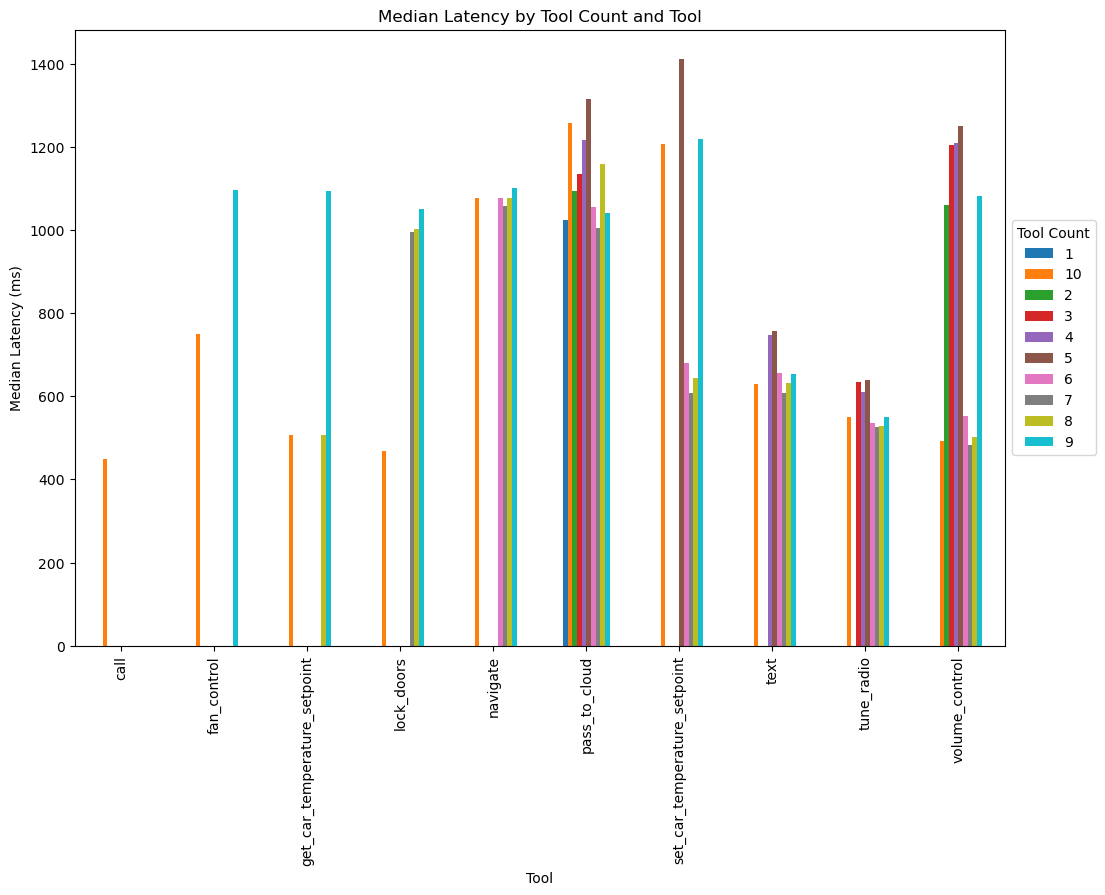

In [30]:
# Pivot the DataFrame to have tool counts as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='tool_count', values='median_latency')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Median Latency by Tool Count and Tool')
plt.xlabel('Tool')
plt.ylabel('Median Latency (ms)')
plt.legend(title='Tool Count', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

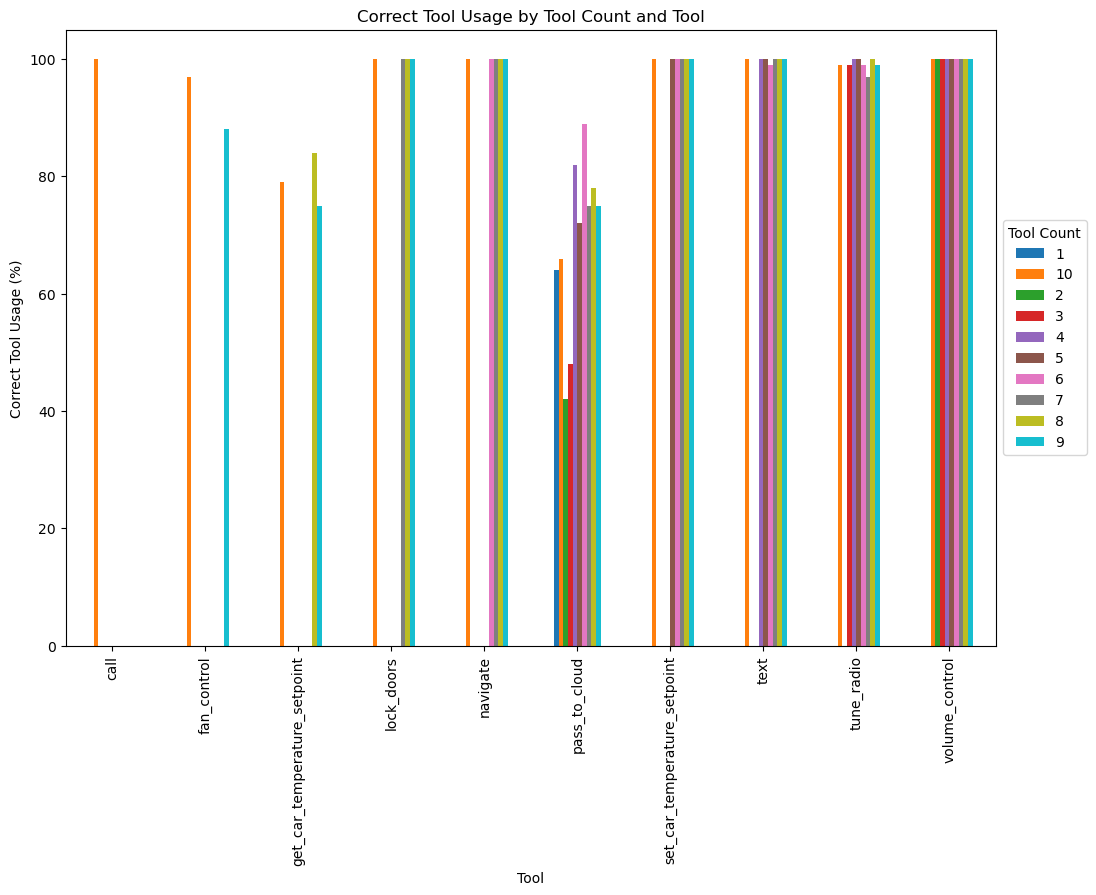

In [31]:
pivot_df = df.pivot(index='tool', columns='tool_count', values='pass_percentage')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Correct Tool Usage by Tool Count and Tool')
plt.xlabel('Tool')
plt.ylabel('Correct Tool Usage (%)')
plt.legend(title='Tool Count', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

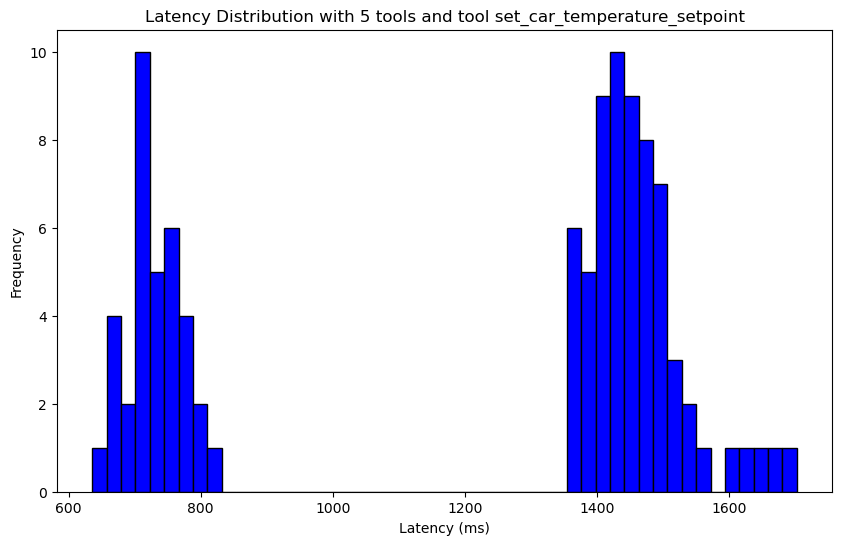

In [32]:
import numpy as np
import matplotlib.pyplot as plt

tool_count = '5'
tool_name = 'set_car_temperature_setpoint'

five_tool_count = data[tool_count]
latencies = five_tool_count[tool_name]['latencies']

# Create bins for the histogram
min_latency = min(latencies)
max_latency = max(latencies)
bins = np.linspace(min_latency, max_latency, 50)

# Plotting the latency distribution
plt.figure(figsize=(10, 6))
plt.hist(latencies, bins=bins, edgecolor='black', color='blue')

plt.title(f'Latency Distribution with {tool_count} tools and tool {tool_name}')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Are there user inputs that are more likely to fail?
# How does hardware effect latency (4800 vs. M1 Max vs M4)?